# Ungraded Lab: Subword Tokenization with the IMDB Reviews Dataset

In this lab, you will look at tokenizing a dataset using subword text encoding. This is an alternative to word-based tokenization which you have been using in the previous labs. You will see how it works and its effect on preparing your data and training your model.

Let's begin!


## Lab Setup

First, you will install some additional packages in Colab and import the ones you will use in the next sections.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp

## Load the IMDB Reviews dataset

As you did in the first ungraded lab, you will load the [IMDB Reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) dataset from Tensorflow Datasets.

In [2]:
# Load the dataset
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir='./data', download=False)

Then, extract the reviews and labels so you can preprocess them.

In [3]:
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

You can preview a few reviews as a sanity check.

In [4]:
# Show two reviews
list(train_reviews.take(2))

[<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">,
 <tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. Howev

## Subword Tokenization

From previous labs, the number of tokens in the sequence is the same as the number of words in the text (i.e. word tokenization). The following cells shows a review of this process.

In [5]:
# Parameters for tokenization and padding
VOCAB_SIZE = 10000
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [6]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE
)

# Generate the vocabulary based only on the training set
vectorize_layer.adapt(train_reviews)

In [7]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), 
                                                  maxlen=MAX_LENGTH, 
                                                  truncating=TRUNC_TYPE, 
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [8]:
# Apply the vectorization layer and padding on the training inputs
train_sequences = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

The cell above uses a `vocab_size` of 10000 but you'll find that it's easy to find OOV tokens when decoding using the lookup dictionary it created. See the result below and notice the `[UNK]` tags:

In [9]:
# Get the vocabulary
imdb_vocab_fullword = vectorize_layer.get_vocabulary()

# Get a sample integer sequence
sample_sequence = train_sequences.take(1).get_single_element()

# Lookup each token in the vocabulary
decoded_text = [imdb_vocab_fullword[token] for token in sample_sequence]

# Combine the words
decoded_text = ' '.join(decoded_text)

# Print the output
print(decoded_text)

    this was an absolutely terrible movie dont be [UNK] in by christopher walken or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the [UNK] rebels were making their cases for [UNK] maria [UNK] [UNK] appeared phony and her [UNK] affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher [UNK] good name i could barely sit through it


For binary classifiers, this might not have a big impact but you may have other applications that will benefit from avoiding OOV tokens when training the model (e.g. text generation). If you want the tokenizer above to not have OOVs, then you might have to increase the vocabulary size to more than 88k. Right now, it's only at 10k. This can slow down training and bloat the model size. The encoder also won't be robust when used on other datasets which may contain new words, thus resulting in OOVs again.

*Subword text encoding* gets around this problem by using parts of the word to compose whole words. This makes it more flexible when it encounters uncommon words. You can use the [KerasNLP](https://keras.io/api/keras_nlp/) API to do just that.

First, you will compute the subword vocabulary using the [compute_word_piece_vocabulary()](https://keras.io/api/keras_nlp/tokenizers/compute_word_piece_vocabulary/#compute_word_piece_vocabulary-function) function. You will tell it to:
* learn from the `train_reviews`
* set a max vocabulary size of 8k
* reserve special tokens similar to the full word vocabulary
* save the output to a file in the current directory

***Note: This will take around 5 minutes to run. If you want to save some time, you can skip it and download the subword vocabulary in the next cell.***

In [10]:
# Compute the subword vocabulary and save to a file
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_reviews,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file='imdb_vocab_subwords.txt'
)

Next, you will initialize a [WordPieceTokenizer](https://keras.io/api/keras_nlp/tokenizers/word_piece_tokenizer/#wordpiecetokenizer-class) using the vocabulary. This will behave similar to the `TextVectorization` layer you've been using so far, but it is able to generate subword sequences.

In [11]:
# Uncomment this line if you skipped the cell above and want to use a pre-saved vocabulary
# !wget -nc https://storage.googleapis.com/tensorflow-1-public/course3/imdb_vocab_subwords.txt

In [12]:
# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./imdb_vocab_subwords.txt'
)

See the vocabulary below. You'll notice that many of them are just parts of words, sometimes just single characters. Some also have a `##` which indicates that it is a suffix (i.e. something that is connected to a previous token). You'll see how this behaves later with an example.

In [13]:
# Print the subwords
subword_tokenizer.get_vocabulary()

['[PAD]',
 '[UNK]',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 '',
 '¡',
 '¢',
 '£',
 '¤',
 '¦',
 '§',
 '¨',
 '«',
 '®',
 '°',
 '³',
 '´',
 '·',
 'º',
 '»',
 '½',
 '¾',
 '¿',
 'À',
 'Á',
 'Ã',
 'Ä',
 'Å',
 'È',
 'É',
 'Ê',
 'Õ',
 'Ø',
 'Ü',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'î',
 'ï',
 'ð',
 'ñ',
 'ò',
 'ó',
 'ô',
 'ö',
 'ø',
 'ù',
 'ú',
 'û',
 'ü',
 'ý',
 'ō',
 '–',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '₤',
 '\uf0b7',
 't

If you use it on the previous plain text sentence, you'll see that it won't have any OOVs even if it has a smaller vocab size (only around 8k compared to 10k above):

In [14]:
# Show the size of the subword vocabulary
subword_tokenizer.vocabulary_size()

7635

In [15]:
# Get a sample review
sample_review = train_reviews.take(1).get_single_element()

# Encode the first plaintext sentence using the subword text encoder
tokenized_string = subword_tokenizer.tokenize(sample_review)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode the sequence
original_string = subword_tokenizer.detokenize(tokenized_string)

# Print the result
print('The original string: {}'.format(original_string))

Tokenized string is [ 209  175  195  674  630  178   15  680    8   85  189   77 2000  170
  192 1766 4426  203  700   42 1864 2116   15 1961  185  255  328   13
  182  173  392  535  189  231  442  390  170  740   15  597  231  255
  282  263  186 1680 6036  173  178    8   84  908 1045   15  209  178
  168  195  638 4963 1657 1422 3263  637   15  176  258 1648  312  234
  330  223  164   36 1532 5576  758  326 4207  174  234  415  231 3925
  180 4554  174   15 3651   36  363 6855 1985 2230 1828  303 1931 7070
   13  165  202 5417   14  298 2118  179 4426  175  353  182   66 1648
 1210   81 7017  170   66  178  172  175 5789  166  269  324 1606   15
   42  427  938  172  219  185  266  199  173   13 3231  204  471    8
   84  199 1766 4426    8   84  210  627   15   42  263 1575 1169  320
  171   15]
The original string: b"This was an absolutely terrible movie . Don ' t be lured in by Christopher Walken or Michael Ironside . Both are great actors , but this must simply be their worst 

Subword encoding can even perform well on words that are not commonly found in movie reviews. First, see the result when using the full-word tokenizer. As expected, it will show many unknown words.

In [16]:
# Define sample sentence
sample_string = 'TensorFlow, from basics to mastery'

# Encode using the plain text tokenizer
tokenized_string = vectorize_layer(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
decoded_text = [imdb_vocab_fullword[token] for token in tokenized_string]
original_string = ' '.join(decoded_text)
print ('The original string: {}'.format(original_string))

Tokenized string is [ 1 36  1  6  1]
The original string: [UNK] from [UNK] to [UNK]


Then compare to the subword tokenizer:

In [17]:
# Encode using the subword text encoder
tokenized_string = subword_tokenizer.tokenize(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

# Decode and print the results
original_string = subword_tokenizer.detokenize(tokenized_string).numpy().decode("utf-8")
print('The original string: {}'.format(original_string))


Tokenized string is [  53 2235  543 1827 3024   13  198 1659  174  167 2220  238]
The original string: TensorFlow , from basics to mastery


As you may notice, the sentence is correctly decoded. The downside is the token sequence is much longer. Instead of only 5 when using the full-word tokenizer, you ended up with 12 tokens instead. The mapping for this sentence is shown below:

In [18]:
# Show token to subword mapping:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, subword_tokenizer.detokenize([ts]).numpy().decode("utf-8")))

53 ----> T
2235 ----> ##ens
543 ----> ##or
1827 ----> ##F
3024 ----> ##low
13 ----> ,
198 ----> from
1659 ----> basic
174 ----> ##s
167 ----> to
2220 ----> master
238 ----> ##y


## Training the model

You will now train your model using the subword-tokenized dataset using the same process as before.

In [19]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

Next, you will build the model. You can just use the architecture from the previous lab.

In [20]:
# Define dimensionality of the embedding
EMBEDDING_DIM = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 64)        │       488,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,037 (1.87 MB)

 Trainable params: 489,037 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

Similarly, you can use the same parameters for training. In Colab, it will take around 10 to 15 seconds per epoch (without an accelerator) and you will reach around 92% training accuracy and 77% validation accuracy.

In [21]:
num_epochs = 10

# Set the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Start training
history = model.fit(train_dataset_final, epochs=num_epochs, validation_data=test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6699 - loss: 0.6093 - val_accuracy: 0.7906 - val_loss: 0.4433
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8394 - loss: 0.3703 - val_accuracy: 0.7985 - val_loss: 0.4327
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8733 - loss: 0.3128 - val_accuracy: 0.7936 - val_loss: 0.4535
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8845 - loss: 0.2843 - val_accuracy: 0.7887 - val_loss: 0.4795
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8927 - loss: 0.2659 - val_accuracy: 0.7835 - val_loss: 0.5074
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8977 - loss: 0.2528 - val_accuracy: 0.7800 - val_loss: 0.5334
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9034 - loss: 0.2423 - val_accuracy: 0.7765 - val_loss: 0.5589
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9091 - loss: 0.2338 - val_accuracy: 0

## Visualize the results

You can use the cell below to plot the training results. See if you can improve it by tweaking the parameters such as the size of the embedding and number of epochs.

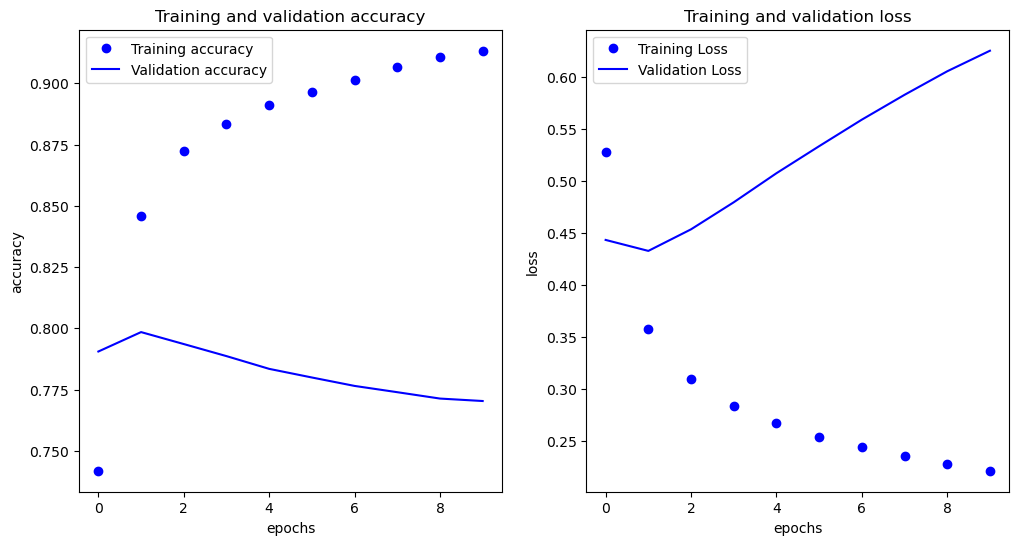

In [22]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

## Wrap Up

In this lab, you saw how subword tokenization can be a robust technique to avoid out-of-vocabulary tokens. It can decode uncommon words it hasn't seen before even with a relatively small vocab size. Consequently, it results in longer token sequences when compared to full word tokenization. Next week, you will look at other architectures that you can use when building your classifier. These will be recurrent neural networks and convolutional neural networks.